# Project 3: Web APIs & NLP

**Subreddits: Startups and Streaming**

In [68]:
import pandas as pd
import datetime as dt
import time
import requests
import regex as re
import numpy as np
import requests
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords 
from bs4 import BeautifulSoup  
%matplotlib inline
import string


# DATA COLLECTION

**URL request**

In [69]:
startup_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit=startups'
streaming_url = 'https://api.pushshift.io/reddit/search/submission/?subreddit=streaming'


In [70]:
res_startup = requests.get(startup_url)
res_streaming = requests.get(streaming_url)

In [71]:
# Explicitly get the status code
print(res_startup.status_code)
print(res_streaming.status_code)

200
200


**Extract the data**

In [72]:
# Convert to JSON: dictionary
json_startup = res_startup.json()
json_streaming= res_streaming.json()

json_startup


{'data': [{'all_awardings': [],
   'allow_live_comments': False,
   'author': 'casablanca305',
   'author_flair_css_class': None,
   'author_flair_richtext': [],
   'author_flair_text': None,
   'author_flair_type': 'text',
   'author_fullname': 't2_168v8f',
   'author_patreon_flair': False,
   'author_premium': False,
   'awarders': [],
   'can_mod_post': False,
   'contest_mode': False,
   'created_utc': 1588040411,
   'domain': 'self.startups',
   'full_link': 'https://www.reddit.com/r/startups/comments/g9epm1/digital_products_startup_giving_cofounder_profit/',
   'gildings': {},
   'id': 'g9epm1',
   'is_crosspostable': True,
   'is_meta': False,
   'is_original_content': False,
   'is_reddit_media_domain': False,
   'is_robot_indexable': True,
   'is_self': True,
   'is_video': False,
   'link_flair_background_color': '#646d73',
   'link_flair_richtext': [],
   'link_flair_template_id': '33eee056-60af-11ea-a1f0-0e4d6c8cf083',
   'link_flair_text': 'General Startup Discussion',
   

In [73]:
print(json_startup.keys())
print(json_streaming.keys())

dict_keys(['data'])
dict_keys(['data'])


In [74]:
print(len(json_startup['data']))
print(len(json_streaming['data']))

25
25


**Convert to dataframe**

In [75]:
startup_df = pd.DataFrame(json_startup["data"])
startup_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,whitelist_status,wls,link_flair_css_class,removed_by_category,post_hint,preview,author_flair_background_color,author_flair_text_color,banned_by,edited
0,[],False,casablanca305,None,[],None,text,t2_168v8f,False,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,jacobnjfin,None,[],None,text,t2_4b6h44z4,False,False,...,all_ads,6,RESOURCE,moderator,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,TheBodhizaffa,None,[],None,text,t2_m0dplpg,False,False,...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,throwaway989973920,None,[],None,text,t2_6bde0zlo,False,False,...,all_ads,6,NaN,moderator,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,hikamp68,None,[],None,text,t2_44x34lf8,False,False,...,all_ads,6,HOWDOI,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
streaming_df = pd.DataFrame(json_streaming['data'])
streaming_df.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,url,whitelist_status,wls,post_hint,preview,removed_by_category,author_flair_background_color,author_flair_text_color,crosspost_parent,crosspost_parent_list
0,[],False,WeAreAllUgly69,None,[],None,text,t2_5o3blupp,False,False,...,https://www.reddit.com/r/streaming/comments/g9...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,collinmckinlay,None,[],None,text,t2_5hykwz8h,False,False,...,https://www.reddit.com/r/streaming/comments/g9...,all_ads,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,_starbust_,None,[],None,text,t2_1jcf37b7,False,False,...,https://www.reddit.com/r/streaming/comments/g9...,all_ads,6,self,"{'enabled': False, 'images': [{'id': '0jhSV58R...",NaN,NaN,NaN,NaN,NaN
3,[],False,Operator-Lime,None,[],None,text,t2_69gspuz0,False,False,...,https://www.reddit.com/r/streaming/comments/g9...,all_ads,6,self,"{'enabled': False, 'images': [{'id': '9bLDwJfx...",NaN,NaN,NaN,NaN,NaN
4,[],False,Cap-soty,None,[],None,text,t2_2f5aknxd,False,False,...,https://www.reddit.com/r/streaming/comments/g9...,all_ads,6,self,"{'enabled': False, 'images': [{'id': 'b7iF9foU...",NaN,NaN,NaN,NaN,NaN


**Data collection**

In [77]:
def query_pushshift(subreddit, kind = 'submission', day_window = 30, n = 5):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # BASE_URL & Parameters
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" 
    size = 1000
    day_window = 7
    
    
    # instantiate empty list for temp storage
    posts = []
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        response = requests.get(BASE_URL,
                                params = {
                                    'subreddit': subreddit,
                                    'size': size,
                                    'after': f'{day_window*i}d'
                                })
        print(f'Getting data from subreddit {subreddit} after {day_window*i} days')
        assert response.status_code == 200
        json = response.json()['data']
        df = pd.DataFrame.from_dict(json)
        posts.append(df)
        time.sleep(2)
    
    # pd.concat storage list
    full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full 

In [78]:
startup_df = query_pushshift('startups')

Getting data from subreddit startups after 7 days
Getting data from subreddit startups after 14 days
Getting data from subreddit startups after 21 days
Getting data from subreddit startups after 28 days
Getting data from subreddit startups after 35 days
Query Complete!


In [79]:
streaming_df = query_pushshift('streaming')

Getting data from subreddit streaming after 7 days
Getting data from subreddit streaming after 14 days
Getting data from subreddit streaming after 21 days
Getting data from subreddit streaming after 28 days
Getting data from subreddit streaming after 35 days
Query Complete!


In [80]:
startup_df.shape

(2078, 9)

In [81]:
streaming_df.shape

(2829, 9)

# Data cleaning and EDA

**Removed duplicate from authors**

In [82]:
# remove rows with duplicated author to have well distributed opinions
startup_df.drop_duplicates(subset='author',inplace=True)
streaming_df.drop_duplicates(subset='author',inplace=True)

print(len(startup_df))
print(len(streaming_df))

1339
1502


In [83]:
startup_df.to_csv('./startups_df')


In [84]:
streaming_df.to_csv('./streaming_df')

**Nulls**

In [85]:
#check for nulls

startup_df.isnull().sum()

title           0
selftext        1
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [86]:
startup_df = startup_df.dropna()

In [87]:
startup_df.isnull().sum()

title           0
selftext        0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [88]:
streaming_df.isnull().sum()

title           0
selftext        0
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [89]:
startup_df.shape

(1338, 9)

In [90]:
streaming_df.shape

(1502, 9)

**Summary**

In [91]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 369
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1338 non-null   object
 1   selftext      1338 non-null   object
 2   subreddit     1338 non-null   object
 3   created_utc   1338 non-null   int64 
 4   author        1338 non-null   object
 5   num_comments  1338 non-null   int64 
 6   score         1338 non-null   int64 
 7   is_self       1338 non-null   bool  
 8   timestamp     1338 non-null   object
dtypes: bool(1), int64(3), object(5)
memory usage: 95.4+ KB


In [92]:
streaming_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1502 entries, 0 to 469
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         1502 non-null   object
 1   selftext      1502 non-null   object
 2   subreddit     1502 non-null   object
 3   created_utc   1502 non-null   int64 
 4   author        1502 non-null   object
 5   num_comments  1502 non-null   int64 
 6   score         1502 non-null   int64 
 7   is_self       1502 non-null   bool  
 8   timestamp     1502 non-null   object
dtypes: bool(1), int64(3), object(5)
memory usage: 107.1+ KB


**Combination of dataframes**

In [93]:
combined = pd.concat([startup_df, streaming_df], axis=0).reset_index(drop=True)
combined.to_csv('./combined_df')

In [94]:
combined['subreddit'] = combined['subreddit'].apply(lambda  x: 1 if x == 'startups' else 0)

In [95]:
combined.shape

(2840, 9)

In [96]:
combined['alltext'] = combined['title'] + combined['selftext']

In [97]:
combined.head(2)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,alltext
0,"Hi guys, made a discord channel where we bounc...",[removed],1,1587438762,AhelpinHand,2,1,True,2020-04-20,"Hi guys, made a discord channel where we bounc..."
1,MY BRAND NEED HELP,Hello. My name is Vasco Ferreira and I am a yo...,1,1587440491,Birro97,0,1,True,2020-04-20,MY BRAND NEED HELPHello. My name is Vasco Ferr...


**Check which words to remove**

In [98]:
# Instantiate Tokenizer
rt = RegexpTokenizer(r'\w+')

In [99]:
list(string.punctuation)

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [100]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    stops.update(list(string.punctuation))
    words_add = ['removed', 'http', 'startup', 'startups', 'streaming']
    stops.update(list(words_add))
    
    
    # 5. Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [101]:
combined['clean_text'] =  combined.alltext.map(review_to_words)

C:\Users\alirodqui\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://www.twitch.tv/eiloggwelcomeeeeeeeeee" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\alirodqui\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "https://youtu.be/59rtOZ2mUUo[removed]" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [102]:
#ser X and y
X = combined['clean_text'] 
y = combined['subreddit']

In [103]:
combined.subreddit.value_counts()

0    1502
1    1338
Name: subreddit, dtype: int64

# Preprocessing and Modeling

**Baseline Score**

In [104]:
y.value_counts(normalize=True)

0    0.528873
1    0.471127
Name: subreddit, dtype: float64

**Train, test and split**

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, stratify =y, random_state = 42)


In [106]:
# check train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1902,)
(938,)
(1902,)
(938,)


**Lemmatokenizer**

In [107]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Models

**Parameters**

|Max Features |Stop words  | N grams  |
|---|---|---|
| 100  | None  |(1,1)   |
| 250   |English   | (1,2)  |
|500   |   |   |
|1000   |   |   |

**1)  Countvectorizer with Logistic Regression**

In [108]:
pipe_cv = Pipeline(steps= [('cvec', CountVectorizer(tokenizer = LemmaTokenizer())),
            ('model_cv', LogisticRegression())])

pipe_td = Pipeline(steps= [('tvec', TfidfVectorizer(tokenizer = LemmaTokenizer())),
            ('model_td', LogisticRegression()) ])

# Construct Grid Parameters for CountVectorizer
hyperparams_cv = {'cvec__ngram_range': [(1,1), (1,2)],
                   'cvec__stop_words': [None,'english'], 
                    'cvec__max_features': [100, 250, 500, 1000]}

# Construct Grid Parameters for TDIDFFVectorizer
hyperparams_td = {'tvec__ngram_range': [(1,1), (1,2)],
               'tvec__stop_words': [None, 'english'],
               'tvec__max_features': [100, 250, 500, 1000]}



In [109]:
#gridsearch cv
gs_cv = GridSearchCV(pipe_cv, param_grid=hyperparams_cv, cv=3,n_jobs=4, scoring = 'accuracy')

#fit
gs_cv.fit(X_train, y_train)


C:\Users\alirodqui\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [110]:
# best score
print(gs_cv.best_score_)

# Save best model as gs_model.
gs_modelc = gs_cv.best_estimator_

# Score model on training set.
print(gs_modelc.score(X_train, y_train))

# Score model on testing set.
print(gs_modelc.score(X_test, y_test))

0.9500525762355415
0.9894847528916929
0.9509594882729211


In [111]:
#gs_modelc.named_steps['cvec'].get_feature_names()

In [112]:
y_predict = gs_modelc.predict(X_test) #predict


In [113]:
#create a confusion matrix
cvl = confusion_matrix(y_test, y_predict)
cvl_df = pd.DataFrame(cvl, columns = ['predict_negative', 'predict_positive'],
                     index=['actual negative', 'actual positive'])
    
print(f' confusion matrix: \n{cvl_df}\n\n')


 confusion matrix: 
                 predict_negative  predict_positive
actual negative               460                36
actual positive                10               432




Bias towards Type I: False positive

In [114]:
tp = 429
tn = 425
fp = 37
fn = 7


# confusion matrix metrics
accuracy = 1 - (fp+fn)/(tp+fp+fn+tn)
misclassification = (fp+fn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Misclassification:',round(misclassification,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')


Accuracy: 0.951
Misclassification: 0.049
Sensitivity: 0.984
Specificity: 0.92
Precision: 0.921



**2) Tfidf**

In [115]:
#gridsearch td
gs_td = GridSearchCV(pipe_td, param_grid=hyperparams_td, cv=3,n_jobs=4, scoring = 'accuracy')

#fit
gs_td.fit(X_train, y_train)

C:\Users\alirodqui\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [116]:
# What's the best score?
print(gs_td.best_score_)

# Save best model as gs_model.

gs_modelt = gs_td.best_estimator_

# Score model on training set.
print(gs_modelt.score(X_train, y_train))

# Score model on testing set.
print(gs_modelt.score(X_test, y_test))

0.956887486855941
0.9768664563617245
0.9541577825159915


In [117]:
y_predict_tfidf = gs_modelt.predict(X_test) #predict

#create a confusion matrix
cmt = confusion_matrix(y_test, y_predict_tfidf)
cmt_df = pd.DataFrame(cmt, columns = ['predict_negative', 'predict_positive'],
                     index=['actual negative', 'actual positive'])
    
print(f' confusion matrix: \n{cmt_df}\n\n')


 confusion matrix: 
                 predict_negative  predict_positive
actual negative               459                37
actual positive                 6               436




Bias towards Type I: False positive

In [118]:
tp = 432
tn = 426
fp = 36
fn = 4

# confusion matrix metrics
accuracy = 1 - (fp+fn)/(tp+fp+fn+tn)
misclassification = (fp+fn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Misclassification:',round(misclassification,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')


Accuracy: 0.955
Misclassification: 0.045
Sensitivity: 0.991
Specificity: 0.922
Precision: 0.923



**Naive Bayes**

In [119]:
# Construct Grid Parameters for CountVectorizer
hyperparams_cvm = {'cvec__ngram_range': [(1,1), (1,2)],
               'cvec__stop_words': [None,'english'],
               'cvec__max_features': [100, 250, 500, 1000]}

# Construct Grid Parameters for TDIDFFVectorizer
hyperparams_tdm = {'tvec__ngram_range': [(1,1), (1,2)],
               'tvec__stop_words': [None, 'english'],
               'tvec__max_features': [100, 250, 500, 1000]}

**Countvectorizer Multinomial Bayes**

In [120]:
#multinomial bayes
pipe_cv_m = Pipeline([
            ('cvec', CountVectorizer(tokenizer = LemmaTokenizer())),
            ('mnb', MultinomialNB())    
])
gs_cv_m = GridSearchCV(pipe_cv_m, param_grid=hyperparams_cvm, verbose=1,cv=3,n_jobs=4)
gs_cv_m.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   45.1s finished
C:\Users\alirodqui\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [121]:
# What's the best score?
print(gs_cv_m.best_score_)

# Save best model as gs_model.

gs_modelm = gs_cv_m.best_estimator_

# Score model on training set.
print(gs_modelm.score(X_train, y_train))

# Score model on testing set.
print(gs_modelm.score(X_test, y_test))

0.9453207150368034
0.9495268138801262
0.9339019189765458


In [122]:
y_predict_na = gs_modelm.predict(X_test) #predict

#create a confusion matrix
cmb = confusion_matrix(y_test, y_predict_na)
cmb_df = pd.DataFrame(cmb, columns = ['predict_negative', 'predict_positive'],
                     index=['actual negative', 'actual positive'])
    
print(f' confusion matrix: \n{cmb_df}\n\n')


 confusion matrix: 
                 predict_negative  predict_positive
actual negative               474                22
actual positive                40               402




Bias towards Type II: False negative

In [123]:
tp = 408
tn = 443
fp = 19
fn = 28

# confusion matrix metrics
accuracy = 1 - (fp+fn)/(tp+fp+fn+tn)
misclassification = (fp+fn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Misclassification:',round(misclassification,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')


Accuracy: 0.948
Misclassification: 0.052
Sensitivity: 0.936
Specificity: 0.959
Precision: 0.956



**Tfidf Gaussian**

In [124]:
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 

In [125]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    '''
    This class is to transform a sparse matrix into a dense matrix.
    The Gaussian NB required a dense matrix, and the vectorizer return a sparse matrix.
        
    '''
    def __init__( self ):
        pass 
  
    def fit( self, X, y = None ):
        return self 

    def transform( self, X, y = None ):
        return X.todense()

In [126]:
pipe_td_m = Pipeline([
            ('tvec', TfidfVectorizer(tokenizer = LemmaTokenizer())),
            ('denset', DenseTransformer()),  # our custom transformer
            ('gnb', GaussianNB())    
])
gs_td_m = GridSearchCV(pipe_td_m, param_grid = hyperparams_tdm, verbose=1,cv=3,scoring = 'accuracy',n_jobs=4)
gs_td_m.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   44.8s finished
C:\Users\alirodqui\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [127]:
# What's the best score?
print(gs_td_m.best_score_)

# Save best model as gs_model.

gs_modelg = gs_td_m.best_estimator_

# Score model on training set.
print(gs_modelg.score(X_train, y_train))

# Score model on testing set.
print(gs_modelg.score(X_test, y_test))

0.9421661409043112
0.964248159831756
0.9488272921108742


In [128]:
y_predict_ga = gs_modelg.predict(X_test) #predict

#create a confusion matrix
cmg = confusion_matrix(y_test, y_predict_ga)
cmg_df = pd.DataFrame(cmg, columns = ['predict_negative', 'predict_positive'],
                     index=['actual negative', 'actual positive'])
    
print(f' confusion matrix: \n{cmg_df}\n\n')


 confusion matrix: 
                 predict_negative  predict_positive
actual negative               467                29
actual positive                19               423




Bias towards Type I: False positive

In [129]:
tp = 411
tn = 431
fp = 31
fn = 25

# confusion matrix metrics
accuracy = 1 - (fp+fn)/(tp+fp+fn+tn)
misclassification = (fp+fn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print('Accuracy:',round(accuracy,3))
print('Misclassification:',round(misclassification,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))
print('')


Accuracy: 0.938
Misclassification: 0.062
Sensitivity: 0.943
Specificity: 0.933
Precision: 0.93




**Models Accruracy scores**

|Models   |Train Score   |Test Score   |
|---|---|---|
|Count Vec -Linear Reg  |0.989  | 0.945  |
|TFIDF - Linear Reg     | 0.978  |0.934  |
|Count Vec - Multinomial NB   |0.952   |0.939  |
|TFIDF - Gaussian NB    |0.972  |0.936   |

**Metrics**

In [130]:
df = pd.DataFrame(pipe_cv['cvec'].fit_transform(X_test).toarray(), columns = pipe_cv['cvec'].get_feature_names())

In [131]:
df['preds'] = gs_modelc.predict(X_test)

In [132]:
df.loc[df['preds'] == 0].sum().sort_values(ascending=False)

twitch       439
stream       383
http         341
tv           318
www          272
            ... 
luxury         0
lurker         0
luckily        0
lparticle      0
aaa            0
Length: 6682, dtype: int64

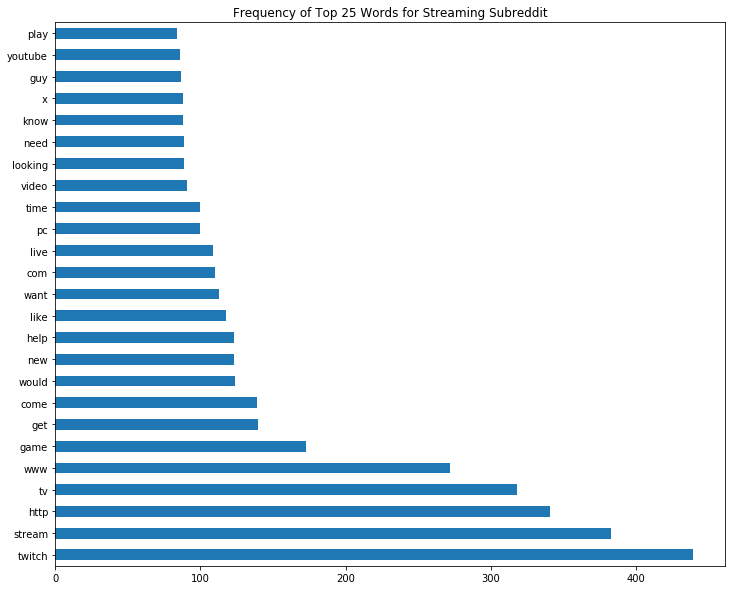

In [133]:
plt.figure(figsize = (12,10))
df.loc[df['preds'] == 0].sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.title('Frequency of Top 25 Words for Streaming Subreddit')
plt.ylabel("")
plt.show()

In [134]:
df.loc[df['preds'] == 1].sum().sort_values(ascending=False)

preds       468
product     181
business    178
would       171
http        151
           ... 
prebuilt      0
predator      0
explode       0
explicit      0
kh            0
Length: 6682, dtype: int64

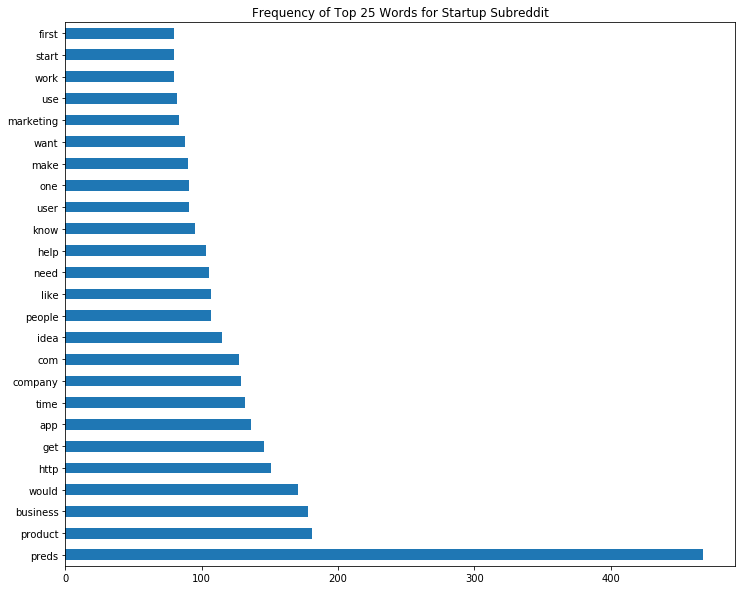

In [135]:
plt.figure(figsize = (12,10))
df.loc[df['preds'] == 1].sum().sort_values(ascending=False).head(25).plot(kind='barh')
plt.title('Frequency of Top 25 Words for Startup Subreddit')
plt.ylabel("")
plt.show()

**Coefficients**

In [136]:

best_cvec = gs_modelc.named_steps['cvec']
best_model = gs_modelc.named_steps['model_cv']


In [137]:
feature_names = best_cvec.get_feature_names()

coefs = best_model.coef_[0,:]


In [138]:
coef_df = pd.DataFrame(data={'coefficient':np.exp(coefs)}, index=feature_names).sort_values(by='coefficient').head(20)
coef_df[coef_df['coefficient'] < 1]

,coefficient
stream,0.037606
twitch,0.067541
tv,0.103515
streamer,0.161199
live,0.170864
camera,0.263005
invite,0.267341
youtu,0.267844
mixer,0.280309
follow,0.319332
